# English to Hindi Translation

This project is aimed to create a machine translation for converting text from English to french using character based sequence to sequence model

In [1]:
import unicodedata
import numpy as np
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")
import nltk

Using TensorFlow backend.


### Data Processing

We will load the parellel corpora text and and then do the below processing

1. Read the data(We are only using the 10000 text from teh corpora as training on the entire corpora is taking too long one epoch is taking hours) 
2. Iterate through teh corpora line by line and extract source and its corrosponding target text.
3. Parse characters of the each sentence for both source and target and store in it a list
4. Create char to index mapping and index to char mapping for both source and target language
    a. This mapping hels us to assign a unique identifier to each character
    b . We can always look for the character given its unique identifiier using reverse mapping

In [15]:
%time
corpora = open('fra.txt', encoding='utf-8').read().split('\n')
src_txts = []
trg_txts = []
# dictionary to index each of the character in the source language 
# [key is index and value is source character]
src_index_to_char_dict = {}
# dictionary to get source character given its index - key is source character and value is index
src_char_to_index_dict = {}
# dictionary to index each of the character in the target language 
# [key is index and value is target character]
trg_index_to_char_dict = {}

# dictionary to get french character given its index 
# [key is target character and value is index]
trg_char_to_index_dict = {}
#ndex of the source language and target language
src_index = 0
trg_index = 1

trg_tokens= set()
sentence_count = 10000

# To store the maximum source and target text length
max_src_len = 0
max_trg_len = 0

# iterate through each sentence and parse the text to extract source and target text and then 
# parse each  character to append to the list of characters. we also need to populate the index 
# to char and char to index dictionary for both source and target sequence

for i in  range(sentence_count):
    textArray = corpora[i].split("\t")
    #unicodedata.normalize('NFD', eng).encode('ascii', 'ignore').decode('UTF-8')
    src_txt = textArray[src_index]
    trg_txt = "".join(['\t',textArray[trg_index], '\n'])
    
    for char in src_txt:
        if char not in src_char_to_index_dict:
            src_char_to_index_dict[char] = len(src_char_to_index_dict)
            src_index_to_char_dict[len(src_index_to_char_dict)] = char
    for char in trg_txt:
        if char not in trg_char_to_index_dict:
            trg_char_to_index_dict[char] = len(trg_char_to_index_dict)
            trg_index_to_char_dict[len(trg_index_to_char_dict)] = char
            
    #find the maximum length text of the source as well as target language
    if len(src_txt) > max_src_len:
        max_src_len = len(src_txt)
    if len(trg_txt) > max_trg_len:
        max_trg_len = len(trg_txt)
        
    src_txts.append(src_txt)
    trg_txts.append(trg_txt)

src_char_tokens = sorted(list(src_char_to_index_dict.keys()))
trg_char_tokens = sorted(list(trg_char_to_index_dict.keys()))

src_index_to_char_dict = {}
src_char_to_index_dict = {}
trg_index_to_char_dict = {}
trg_char_to_index_dict = {}

for char in src_char_tokens:
    if char not in src_char_to_index_dict:
        src_char_to_index_dict[char] = len(src_char_to_index_dict)
        src_index_to_char_dict[len(src_index_to_char_dict)] = char
for char in trg_char_tokens:
    if char not in trg_char_to_index_dict:
        trg_char_to_index_dict[char] = len(trg_char_to_index_dict)
        trg_index_to_char_dict[len(trg_index_to_char_dict)] = char

Wall time: 0 ns


### Feature Mapping

As we know that we need a numeric representation for teh text in order to run a machine learning algorith we need to encode the text data to some numeric reprsentation. We will use use teh below steps to achieve this conversion.

1. We will create 2D matric for each sentence and having size equal to the number of characters in that language and length of the longest text. where each each row represents the one-hot-encoded representation of each character 
2. As we have a 2 matrix for each sentence soe overall we have a 3D matrix where each sentence has 2D matrix representation.


In [16]:
src_tokens = np.zeros(shape=(sentence_count,max_src_len, len(src_char_to_index_dict)), dtype='float32')
trg_tokens = np.zeros(shape=(sentence_count,max_trg_len, len(trg_char_to_index_dict)), dtype='float32')
trg_seq = np.zeros((sentence_count, max_trg_len, len(trg_char_to_index_dict)),dtype='float32')

for i in range(sentence_count):
    src_txt = src_txts[i]
    trg_txt = trg_txts[i]
    for j in range(len(src_txt)):
        char = src_txt[j]
        src_tokens[i,j,src_char_to_index_dict[char]] = 1
        
    for j in range(len(trg_txt)):
        char = trg_txt[j]
        trg_tokens[i,j,trg_char_to_index_dict[char]] = 1
        # Skip the first character to keep make the decorder use the data at next timestep
        if j>0:
            trg_seq[i,j-1,trg_char_to_index_dict[char]] = 1

**Split the data into tran and test**

In [4]:
validation_Size =0.2
idx = np.random.choice(src_tokens.shape[0],size=int(src_tokens.shape[0]*validation_Size),replace=False)

val_src_tokens = src_tokens[idx]
val_trg_tokens = trg_tokens[idx]
val_tar_seq_tokens = trg_seq[idx]

src_tokens = np.delete(src_tokens, idx, axis=0)
trg_tokens = np.delete(trg_tokens, idx, axis=0)
trg_seq = np.delete(trg_seq, idx, axis=0)

val_src_txt = [src_txts[i] for i in idx]
train_src_txt=[src_txts[i] for i in range(len(src_txts)) if i not in idx]

val_trg_txt = [trg_txts[i] for i in idx]
train_trg_txt=[trg_txts[i] for i in range(len(trg_txts)) if i not in idx]

### Sequence to Sequence Model

Now we will creat a sequence to sequence ENcoder Decorder LSTM network which works as below
1. The first network is an LSTM encoder ehich takes the source langauge characters as input and returns the encoded output, hidden state and the cell state.
2. The second network is a decoder network which takes the target character sequence and the encoder hidden and cell state as input and return the decoded output sequence which is passed to a fully connected layer to get the predicted sequence.
3. We have 2 inference model one for encoder and one for decoder which is used to predict the target text for a given source text, the inference model is different then the training model 

In [17]:
class S2SModel:
    def __init__(self, max_src_len, max_trg_len, src_vocab, src_rev_vocab, trg_vocab, trg_rev_vocab, encoder_cell, decoder_cell):
        """
        Constructor for the S2SModel 
        :param src_vocb: longest text length in source language
        :param src_rev_vocb: longest text length in target language
        :param src_vocb: Vocabulary of the source language
        :param src_rev_vocb: Reverse mapping of the source language Vocabulary
        :param trg_vocb: Vocabulary of the source language
        :param trg_rev_vocb: Reverse mapping of the source language Vocabulary
        :param encoder_cell: Number of LSTM, cell to use in encoder
        :param decoder_cell: Number of LSTM, cell to use in decoder
        """
        self.max_src_len = max_src_len
        self.max_trg_len = max_trg_len
        self.src_vocab = src_vocab
        self.src_rev_vocab = src_rev_vocab
        self.trg_vocab = trg_vocab
        self.trg_rev_vocab = trg_rev_vocab
        
        self.src_input_len = len(self.src_vocab)
        self.trg_input_len = len(self.trg_vocab)
        self.encoder_cell = encoder_cell
        self.decoder_cell = decoder_cell
        self.training_model = None
        self.inference_model = None
        self.history = None;
        
    def create(self, activation, optimizer, loss, metrices=None):
        """
        This method creates the network by stacking the required layers 
        :param optimizer: Optimizer to use
        :param loss: loss function to be yused as objective funcion
        :param metrices: list of metrices to report while training
        :return:
        """
        enc_input = Input(shape=(None,self.src_input_len))
        enc_lstm = LSTM(self.encoder_cell,return_state = True)
        enc_output, enc_hidden, enc_cell = enc_lstm(enc_input)
        enc_states = [enc_hidden, enc_cell]
        dec_input = Input(shape=(None,self.trg_input_len))
        # set return_sequences to True so that we obtain the output at every timestep
        dec_lstm = LSTM(self.decoder_cell, return_sequences=True, return_state = True)
        dec_output,_ , _ = dec_lstm(dec_input,enc_states)
        fc_layer = Dense(self.trg_input_len, activation=activation)
        fc_output = fc_layer(dec_output)
        self.training_model = Model (inputs=[enc_input,dec_input],outputs=fc_output)
        if metrices is None:
            self.training_model.compile(optimizer=optimizer, loss=loss)
        else:
            self.training_model.compile(optimizer=optimizer, loss=loss, metrices=metrices)
            
        #encoder inference model
        enc_inf_model = Model(enc_input,enc_states)
        
        #decoder inference model
        dec_input_states = [Input(shape=(self.decoder_cell,)),Input(shape=(self.decoder_cell,))]
        dec_output, dec_hidden, dec_cell = dec_lstm(dec_input, initial_state=dec_input_states)
        fc_output = fc_layer(dec_output)
        dec_inf_model = Model(inputs=[dec_input]+dec_input_states,  outputs=[fc_output]+[dec_hidden, dec_cell])
        self.inference_model={"encoder":enc_inf_model,"decoder":dec_inf_model}
        
    def train(self, enc_input,dec_input, target_sequence, epochs, batch_size=64, validation_data=None):
        """
        This method is used to train the training_model
        :param enc_input: Input for th encoder
        :param dec_input: Input for th decoder
        :param target_sequence: target sequence to predict
        :param epochs: Number of epochs to train
        :param batch_size: size of each batch for training
        :param validation_data: validatin data for the evlauating model
        :return:
        """
        self.history = self.training_model.fit([enc_input,dec_input],target_sequence, epochs=epochs, batch_size=batch_size,
                                      validation_data=validation_data, validation_split=0.2)
    
    
    def predict(self, src_seq):
        """
        This function predicts teh target sequence for a given source sequence
        :param 
        :return
        """
        decoder_input_states = self.inference_model['encoder'].predict(src_seq)
        #Set the start of the sequence
        trg_seq = np.zeros((1, 1, self.trg_input_len))
        trg_seq[0, 0, 0] = 1
        predicted_text = ''
        
        while True:  
            dec_output, dec_hidden, dec_cell = self.inference_model['decoder'].predict(x=[trg_seq]+decoder_input_states)
            predicted_sequence = np.argmax(dec_output[0,-1,:]) 
            predicted_text+=self.trg_rev_vocab[predicted_sequence]
            #Check teh end of sequence marker represented by a new line
            if len(predicted_text) > self.max_trg_len or predicted_sequence == self.trg_vocab["\n"]:
                break
            else:
                #Update the target sequence
                trg_seq = np.zeros((1, 1, self.trg_input_len))
                trg_seq[0, 0, predicted_sequence] = 1
                decoder_input_states = [dec_hidden, dec_cell]
        return predicted_text
    
    def plot_loss(self):
        """
        This function plots the training and validation loss for visualization
        :param 
        :return
        """
        plt.figure(figsize=(5,3))
        plt.plot(S2S.history.history['loss'])
        plt.plot(S2S.history.history['val_loss'])
        plt.legend(["Training Loss", "Validation Loss"])

**Train the Model**

Train on 8000 samples, validate on 2000 samples
Epoch 1/50
8000/8000 [==============================] - 13s 2ms/step - loss: 0.9730 - val_loss: 1.0737
Epoch 2/50
8000/8000 [==============================] - 11s 1ms/step - loss: 0.8689 - val_loss: 0.9572
Epoch 3/50
8000/8000 [==============================] - 11s 1ms/step - loss: 0.7647 - val_loss: 0.8602
Epoch 4/50
8000/8000 [==============================] - 10s 1ms/step - loss: 0.6812 - val_loss: 0.7745
Epoch 5/50
8000/8000 [==============================] - 10s 1ms/step - loss: 0.6253 - val_loss: 0.7369
Epoch 6/50
8000/8000 [==============================] - 11s 1ms/step - loss: 0.5868 - val_loss: 0.6920
Epoch 7/50
8000/8000 [==============================] - 10s 1ms/step - loss: 0.5570 - val_loss: 0.6687
Epoch 8/50
8000/8000 [==============================] - 11s 1ms/step - loss: 0.5308 - val_loss: 0.6392
Epoch 9/50
8000/8000 [==============================] - 11s 1ms/step - loss: 0.5083 - val_loss: 0.6289
Epoch 10/50
8000/8000 [==

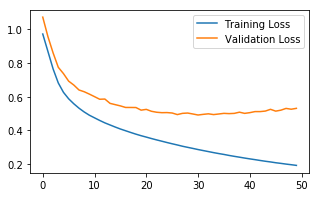

In [18]:
enc_input_len = len(src_char_to_index_dict)
dec_input_len = len(trg_char_to_index_dict)
S2S = S2SModel(max_src_len, max_trg_len, src_char_to_index_dict,src_index_to_char_dict, 
               trg_char_to_index_dict, trg_index_to_char_dict, 256,256)
S2S.create("softmax","rmsprop", "categorical_crossentropy")
S2S.train(src_tokens, trg_tokens, trg_seq, epochs=50, batch_size=128)
S2S.plot_loss()

In [19]:
def compute_avg_bleu_core(src_tokens,src_text, target_text, sample_count, weights):
    """
    It computes teh average bleu score on the given data by takeing some random sample
    :param src_tokens: source text tockens
    :param src_text: source text
    :param target_text: Actual target text
    :param sample_count: Random Sample to take
    :param weights: weights for n-grams
    :return
    """
    index = np.random.choice(source_tokens.shape[0], size=sample_count, replace=False)
    bleu = 0
    for i in index:
        source = src_tokens[index]
        predicted_text = S2S.predict(source)
        target_text = trg_txts[i].strip()
        bleu+=nltk.translate.bleu_score.sentence_bleu([predicted_text],target_text,weights=weights)
        #Print one Candidate Translation
        if i==index[0]:
            print('Target Sentence:', target_text)
            print('Decoded Sentence:', predicted_text)
    return bleu/sample_count

In [20]:
np.random.seed(1)
weights = [1.0, 0, 0, 0]
sample_count = 10 #Number of sentences to consider
source_tokens = src_tokens
source_texts = train_src_txt
target_texts = trg_txts
bleu=compute_avg_bleu_core(source_tokens, source_texts, target_texts,sample_count, weights)
print("The Average bleu score on 10 random text in Training data:%.3f\n"%bleu)

source_tokens = val_src_tokens
source_texts = val_src_txt
target_texts = val_trg_tokens
bleu=compute_avg_bleu_core(source_tokens, source_texts, target_texts,sample_count, weights)
print("The Average bleu score on 10 random text on Validation data:%.3f"%bleu)

Target Sentence: Je ne suis pas nerveuse.
Decoded Sentence: Je ne suis pas sourd.

The Average bleu score on 10 random text in Training data:0.481

Target Sentence: Je suis seul.
Decoded Sentence: Êtes-vous sourd ?

The Average bleu score on 10 random text on Validation data:0.327


In [24]:
np.random.seed(1)
weights = [0.5, 0.5, 0, 0]
sample_count = 10 #Number of sentences to consider
source_tokens = src_tokens
source_texts = train_src_txt
target_texts = trg_txts
bleu=compute_avg_bleu_core(source_tokens, source_texts, target_texts,sample_count, weights)
print("The Average bleu score on 10 random text in Training data:%.3f"%bleu)

source_tokens = val_src_tokens
source_texts = val_src_txt
target_texts = val_trg_tokens
bleu=compute_avg_bleu_core(source_tokens, source_texts, target_texts,sample_count, weights)
print("The Average bleu score on 10 random text on Validation data:%.3f"%bleu)

Target Sentence: Je ne suis pas nerveuse.
Decoded Sentence: Je ne suis pas sourd.

The Average bleu score on 10 random text in Training data:0.304
Target Sentence: Je suis seul.
Decoded Sentence: Êtes-vous sourd ?

The Average bleu score on 10 random text on Validation data:0.144


In [25]:
np.random.seed(1)
weights = [0.33, 0.33, 0.33, 0]
sample_count = 10 #Number of sentences to consider
source_tokens = src_tokens
source_texts = train_src_txt
target_texts = trg_txts
bleu=compute_avg_bleu_core(source_tokens, source_texts, target_texts,sample_count, weights)
print("The Average bleu score on 10 random text in Training data:%.3f"%bleu)

source_tokens = val_src_tokens
source_texts = val_src_txt
target_texts = val_trg_tokens
bleu=compute_avg_bleu_core(source_tokens, source_texts, target_texts,sample_count, weights)
print("The Average bleu score on 10 random text on Validation data:%.3f"%bleu)

Target Sentence: Je ne suis pas nerveuse.
Decoded Sentence: Je ne suis pas sourd.

The Average bleu score on 10 random text in Training data:0.186
Target Sentence: Je suis seul.
Decoded Sentence: Êtes-vous sourd ?

The Average bleu score on 10 random text on Validation data:0.069


**The 1-gram bleu score is 0.50 for the training data and 0.46 for the test data, 2-gram bleu core is 0.33 for training and 0.27 for testing and 3-gram bleu core is 0.19 for training and 0.07 for testing**

In [27]:
S2S.training_model.save("training_model_fr.h5")
S2S.inference_model['encoder'].save("enc_inference_fr.h5")
S2S.inference_model['decoder'].save("dec_inference_fr.h5")

#Note: Save is giving issue with this model